In [391]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [478]:
class LinearRegression:
    
    def __init__(self , iterations, learning_rate, tolerance, solution_type = 'gd' ,regularization = False, regularization_constant = 0):
        self.low_rank = None
        self.full_rank = None
        self.X_test = None
        self.std = None
        self.X_train = None
        self.mean = None
        self.tolerance = tolerance
        self.regularization_constant = regularization_constant
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.solution_type = solution_type
        self.regularization = regularization
        self.regularization_constant = regularization_constant

    def normalize_train_data(self, X_train):
        self.mean = np.mean(X_train, axis=0)
        self.std = np.std(X_train, axis=0)
        self.X_train = (X_train-self.mean)/self.std
        return self.X_train
    
    def normalize_test_data(self, X_test):
        self.X_test = (X_test-self.mean)/self.std
        
        return self.X_test
   
    @staticmethod
    def add_column_zero(self, x):
        x = np.column_stack((np.ones((x.shape[0], 1)), x))
        return x
     
    def full_rank_check(self, X_train):
        rank = np.linalg.matrix_rank(X_train)
        if rank == min(X_train.shape):
            self.full_rank = True
        else:
            self.full_rank = False
        
        return self.full_rank
    
    def low_rank_check(self, X_train):
        if X_train.shape[0] < X_train.shape[1]:
            self.low_rank = True
        else:
            self.low_rank = False
            
        return self.low_rank
        
    def closed_solution(self, X_train, y_train):
        if self.regularization:
            if self.full_rank_check(X_train) and not self.low_rank_check(X_train):
                self.weights = np.matmul(np.linalg.inv(np.matmul(X_train.T,X_train) + self.regularization_constant * np.identity(X_train.shape[1])),(np.matmul(X_train.T,y_train)))
            else:
                print("Matrix is low rank")
                sys.exit()
        else:
            if self.full_rank_check(X_train) and not self.low_rank_check(X_train):
                self.weights = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T.dot(y_train))
            else:
                print("Matrix is low rank")
                sys.exit()
    
    @staticmethod
    def sse_function(self, y_hat ,y ):
        loss = np.sum(np.square(y_hat - y))
        return loss
    
    @staticmethod
    def rmse_function(self, y_hat , y):
        return np.sqrt(self.sse_function(y_hat, y)/y_hat.shape[0])
    
    def cost_derivative(self, X, y):
        return np.matmul(X.T,(np.matmul(X,self.weights)-y))
    
    def gradient_descent(self, X_train, y_train):
        prev_error = np.inf
        errors = list()
        if self.regularization:
            for i in tqdm(range(1,self.iterations), colour='MAGENTA'):
                self.weights -= self.learning_rate*(self.cost_derivative(X_train, y_train) + (self.regularization_constant*self.weights))
                y_hat = np.matmul(X_train,self.weights)
                error = self.rmse_function(y_hat, y_train)
                errors.append(error)
                if np.abs(error-prev_error) < self.tolerance:
                    print("Model Stopped learning")
                    break                
                prev_error = error
        else:
            for i in tqdm(range(1,self.iterations), colour='MAGENTA'):
                self.weights -= self.learning_rate*self.cost_derivative(X_train, y_train)
                error = self.rmse_function(X_train, y_train)
                errors.append(error)
                if np.abs(error-prev_error) < self.tolerance:
                    print("Model Stopped learning")
                    break                
                prev_error = error
        
        self.plot_errors(errors)
    
    @staticmethod
    def plot_errors(self, errors):
        s = np.array(errors)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Error')
        ax.grid()

        plt.show()
        
    def fit(self, X_train, y_train):
        X_train = self.normalize_train_data(X_train)
        X_train = self.add_column_zero(X_train)
        if self.solution_type == 'closed':
            self.closed_solution(X_train, y_train)
        elif self.solution_type == 'gd':
            self.weights = np.zeros(X_train.shape[1])
            self.gradient_descent(X_train, y_train)
        elif self.solution_type == 'sgd':
            self.weights = np.zeros(X_train.shape[1])
            X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)    
            self.gradient_descent(X_train, y_train)
    
    def predict(self, X_test):
        X_test = self.normalize_test_data(X_test)
        X_test = self.add_column_zero(X_test)
        self.y_hat =  np.matmul(X_test, self.weights)
        return self.y_hat
    
    def evaluate(self, X, y, mode):
        if mode == 'train':
            results = self.predict(X)
            sse = self.sse_function(results, y)
            rmse = self.rmse_function(results, y)
            print('Train set RMSE: ', rmse)
            print('Train set SSE: ', sse)
        elif mode == 'test':
            results = self.predict(X)
            sse = self.sse_function(results, y)
            rmse = self.rmse_function(results, y)
            print('Test set RMSE: ', rmse)
            print('Test set SSE: ', sse)
        

Housing Dataset

In [479]:
dataframe = pd.read_csv('housing.csv',header=None)
X = dataframe.iloc[:, :-1]
y = dataframe.iloc[:, -1]

In [480]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)    

Closed Solution

In [481]:
lr = LinearRegression(learning_rate=0.4 * 1e-3,tolerance=0.5 * 1e-2, solution_type='closed', regularization=True, regularization_constant=0.00005, iterations=50000)

In [482]:
lr.fit(X_train, y_train)

In [483]:
lr.evaluate(X_train,y_train,'train')
lr.evaluate(X_test,y_test,'test')

Train set RMSE:  4.490210515560171
Train set SSE:  6834.914770701978
Test set RMSE:  5.122003575909241
Test set SSE:  4381.231745481717


Gradient Descent Solution

In [484]:
lr = LinearRegression(learning_rate=0.4 * 1e-3,tolerance=0.5 * 1e-2, solution_type='gd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 33/49999 [00:00<00:12, 4025.95it/s]

Model Stopped learning


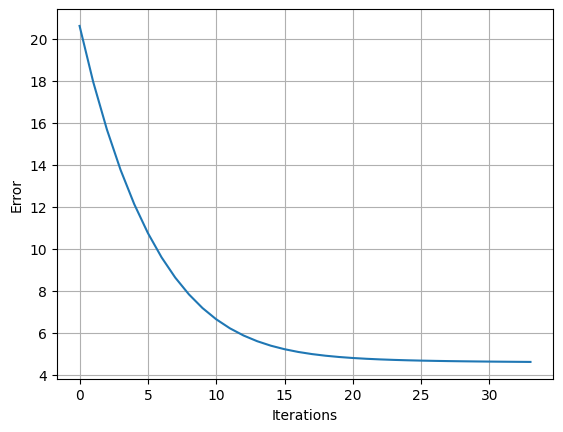

In [485]:
lr.fit(X_train, y_train)

In [486]:
lr.evaluate(X_train,y_train,'train')
lr.evaluate(X_test,y_test,'test')

Train set RMSE:  4.604565837987697
Train set SSE:  7187.487002607174
Test set RMSE:  5.091627607807058
Test set SSE:  4329.420173329364


Stochiastic Gradient Descent

In [487]:
lr = LinearRegression(learning_rate=0.4 * 1e-3,tolerance=0.5 * 1e-2, solution_type='gd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 33/49999 [00:00<00:08, 5795.42it/s]

Model Stopped learning


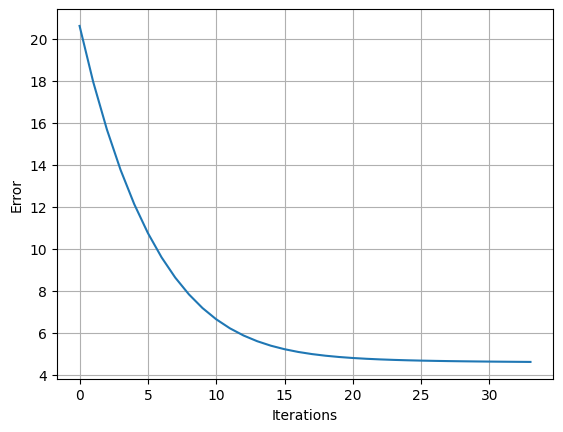

In [488]:
lr.fit(X_train, y_train)

In [489]:
lr.evaluate(X_train,y_train,'train')
lr.evaluate(X_test,y_test,'test')

Train set RMSE:  4.604565837987697
Train set SSE:  7187.487002607174
Test set RMSE:  5.091627607807058
Test set SSE:  4329.420173329364


Concrete Dataset

In [490]:
dataframe = pd.read_csv('concreteData.csv',header=None)
X = dataframe.iloc[:, :-1]
y = dataframe.iloc[:, -1]

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

Closed Solution

In [492]:
lr = LinearRegression(learning_rate=0.7 * 1e-3,tolerance=0.1 * 1e-3, solution_type='closed', regularization=True, regularization_constant=0.00005, iterations=50000)

In [493]:
lr.fit(X_train,y_train)

In [494]:
lr.evaluate(X_train,y_train,'train')
lr.evaluate(X_test,y_test,'test')

Train set RMSE:  10.450029346940386
Train set SSE:  75350.14821282157
Test set RMSE:  10.211771794084349
Test set SSE:  35455.29627931528


Gradient Descent

In [498]:
lr = LinearRegression(learning_rate=0.7 * 1e-3,tolerance=0.1 * 1e-3, solution_type='gd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 131/49999 [00:00<00:10, 4977.34it/s]

Model Stopped learning


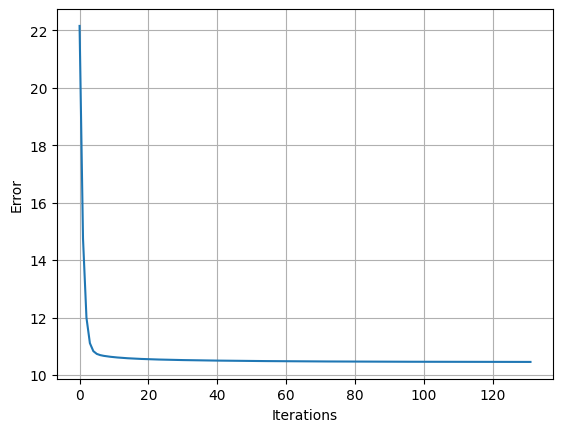

In [499]:
lr.fit(X_train,y_train)

In [500]:
lr.evaluate(X_train,y_train,'train')
lr.evaluate(X_test,y_test,'test')

Train set RMSE:  10.453329919974891
Train set SSE:  75397.75342693117
Test set RMSE:  10.2288929812143
Test set SSE:  35574.28555118595


Stochiastic Gradient Descent

In [501]:
lr = LinearRegression(learning_rate=0.7 * 1e-3,tolerance=0.1 * 1e-3, solution_type='sgd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 130/49999 [00:00<00:10, 4922.40it/s]

Model Stopped learning


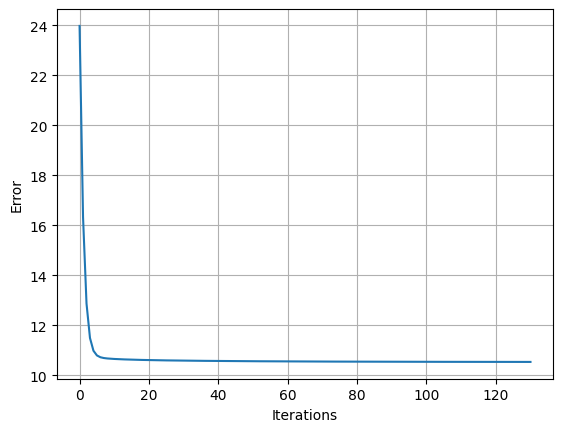

In [502]:
lr.fit(X_train,y_train)

In [503]:
lr.evaluate(X_train, y_train, 'train')
lr.evaluate(X_test, y_test, 'test')

Train set RMSE:  10.482749718577786
Train set SSE:  75822.74874701642
Test set RMSE:  10.336227069202732
Test set SSE:  36324.78060888055


Yacht Dataset

In [504]:
dataframe = pd.read_csv('concreteData.csv',header=None)
X = dataframe.iloc[:, :-1]
y = dataframe.iloc[:, -1]

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

Closed Solution

In [506]:
lr = LinearRegression(learning_rate=0.1 * 1e-2,tolerance=0.1 * 1e-2, solution_type='closed', regularization=True, regularization_constant=0.00005, iterations=50000)

In [507]:
lr.fit(X_train,y_train)

In [508]:
lr.evaluate(X_train, y_train, 'train')
lr.evaluate(X_test, y_test, 'test')

Train set RMSE:  10.450029346940386
Train set SSE:  75350.14821282157
Test set RMSE:  10.211771794084349
Test set SSE:  35455.29627931528


Gradient Descent

In [509]:
lr = LinearRegression(learning_rate=0.1 * 1e-2,tolerance=0.1 * 1e-2, solution_type='gd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 46/49999 [00:00<00:08, 6019.53it/s]

Model Stopped learning


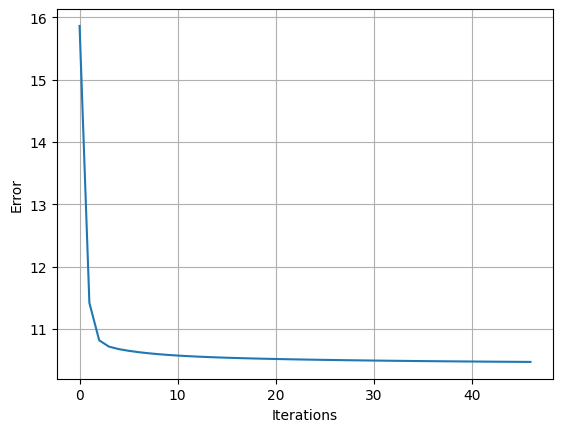

In [510]:
lr.fit(X_train,y_train)

In [511]:
lr.evaluate(X_train, y_train, 'train')
lr.evaluate(X_test, y_test, 'test')

Train set RMSE:  10.472498634461038
Train set SSE:  75674.52707766394
Test set RMSE:  10.271788645554823
Test set SSE:  35873.278272842654


Stochiastic Gradient Descent

In [512]:
lr = LinearRegression(learning_rate=0.1 * 1e-2,tolerance=0.1 * 1e-2, solution_type='sgd', regularization=True, regularization_constant=0.00005, iterations=50000)

  0%|          | 41/49999 [00:00<00:14, 3529.62it/s]

Model Stopped learning


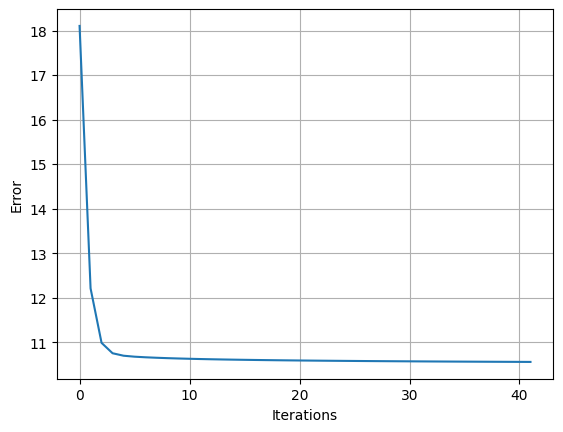

In [513]:
lr.fit(X_train,y_train)

In [514]:
lr.evaluate(X_train, y_train, 'train')
lr.evaluate(X_test, y_test, 'test')

Train set RMSE:  10.515575155031915
Train set SSE:  76298.35138037588
Test set RMSE:  10.396096110587576
Test set SSE:  36746.796875795204
